## measuring memory latency 

The purpose of this notebook is to overcome a problem int the notebook `2_measuring_performance_of_memory_hierarchy.ipynb`.

The problem is that the `time()` function is only accurate up to $10^{-7}$ of a second. So any operations that take a shorter time do not register as taking any time.

To overcome the problem we perform many random pokes in sequence and measure the time it takes to complete all of the pokes.

As we ware interested in times shorter than $10^{-7}$ we restrict our attention to the main memory, rather than to files.

### Import modules

In [2]:
%pylab inline
from numpy import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
import time
from matplotlib.backends.backend_pdf import PdfPages

from os.path import isfile,isdir
from os import mkdir
import os

In [4]:
from lib.measureRandomAccess import measureRandomAccess
from lib.PlotTime import PlotTime

### setting parameters
* We test access to elements arrays whose sizes are:
   * 1MB, 10MB, 100MB, 1000MB (=1GB)
* Arrays are stored **in memory** or **on disk**

* We perform 1 million read/write ops  to random locations in the array.
* We analyze the **distribution** of the latencies.

In [5]:
n=100 # size of single block (1MB)
m_list=[1,10,100,1000,10000] # size of file in blocks
k=100000;  # number of repeats
L=len(m_list)
print('n=%d, k=%d, m_list='%(n,k),m_list)

n=100, k=100000, m_list= [1, 10, 100, 1000, 10000]


### Set working directory
This script generates large files. We put these files in a separate directory so it is easier to delete them later.

In [6]:
log_root='./logs'
if not isdir(log_root): mkdir(log_root)
TimeStamp=str(int(time.time()))
log_dir=log_root+'/'+TimeStamp
mkdir(log_dir)
%cd $log_dir
stat=open('stats.txt','w')

def tee(line):
    print(line)
    stat.write(line+'\n')

/Users/josem/src/docencia/bde/Section1-Spark-Basics/0.MemoryLatency/logs/1539247958


In [8]:
_mean=zeros([2,L])   #0: using disk, 1: using memory
_std=zeros([2,L])
Tmem=[]
TFile=[]

In [9]:
import numpy as np
from numpy.random import rand
import time

def measureRandomAccessMemBlocks(sz,k=1000,batch=100):
    """Measure the distribution of random accesses in computer memory.

    :param sz: size of memory block.
    :param k: number of times that the experiment is repeated.
    :param batch: The number of locations poked in a single experiment (multiple pokes performed using numpy, rather than python loop)
    :returns: (_mean,std,T):
              _mean = the mean of T
              _std = the std of T
              T = a list the contains the times of all k experiments
    :rtype: tuple

    """
    # Prepare buffer.
    A=np.zeros(sz,dtype=np.int8)
            
    # Read and write k*batch times from/to buffer.
    sum=0; sum2=0
    T=np.zeros(k)
    for i in range(k):
        if (i%100==0): print('\r',i, end=' ')
        loc=np.int32(rand(batch)*sz)
        t=time.time()
        x=A[loc]
        A[loc]=loc
        d=(time.time()-t)/batch
        T[i]=d
        sum += d
        sum2 += d*d
    _mean=sum/k; var=(sum2/k)-_mean**2; _std=np.sqrt(var)
    return (_mean,_std,T)

In [10]:
m_list=[10,1000,10000,100000,1000000,10000000,100000000,1000000000]
m_legend=['10B','1KB','10KB','100KB','1MB','10MB','100MB','1GB']

In [11]:
Random_pokes=[]

L=len(m_list)
_mean=zeros([L])   #0: using disk, 1: using memory
_std=zeros([L])
TMem=[0]*L

for m_i in range(L):
    m=m_list[m_i]
    print('Memory array %d Bytes'%m)
    out = measureRandomAccessMemBlocks(m,k=1000,batch=1000)
    (_mean[m_i],_std[m_i],TMem[m_i]) = out
    TMem[m_i].sort()
    tee('\rMemory pokes _mean='+str(_mean[m_i])+', Memory _std='+str(_std[m_i]))

    Random_pokes.append({'m_i':m_i,
                        'm':m,
                        'memory__mean': _mean[m_i],
                        'memory__std': _std[m_i],
                        'memory_largest': TMem[m_i][-100:],
                })

Memory array 10 Bytes
Memory pokes _mean=1.491189002990729e-08, Memory _std=4.5133522410280464e-08
Memory array 1000 Bytes
Memory pokes _mean=1.0909080505371204e-08, Memory _std=1.4150226957524668e-08
Memory array 10000 Bytes
Memory pokes _mean=1.0951995849609492e-08, Memory _std=1.2513795866631589e-08
Memory array 100000 Bytes
Memory pokes _mean=1.3373613357543872e-08, Memory _std=9.896939734156837e-09
Memory array 1000000 Bytes
Memory pokes _mean=1.506090164184562e-08, Memory _std=1.2008756162146998e-08
Memory array 10000000 Bytes
Memory pokes _mean=3.9126634597778136e-08, Memory _std=1.0413200307774711e-07
Memory array 100000000 Bytes
Memory pokes _mean=1.0931372642516964e-07, Memory _std=3.2279925167494967e-07
Memory array 1000000000 Bytes
Memory pokes _mean=1.189178705215456e-06, Memory _std=1.3486604683893824e-06


### Characterize random access to storage

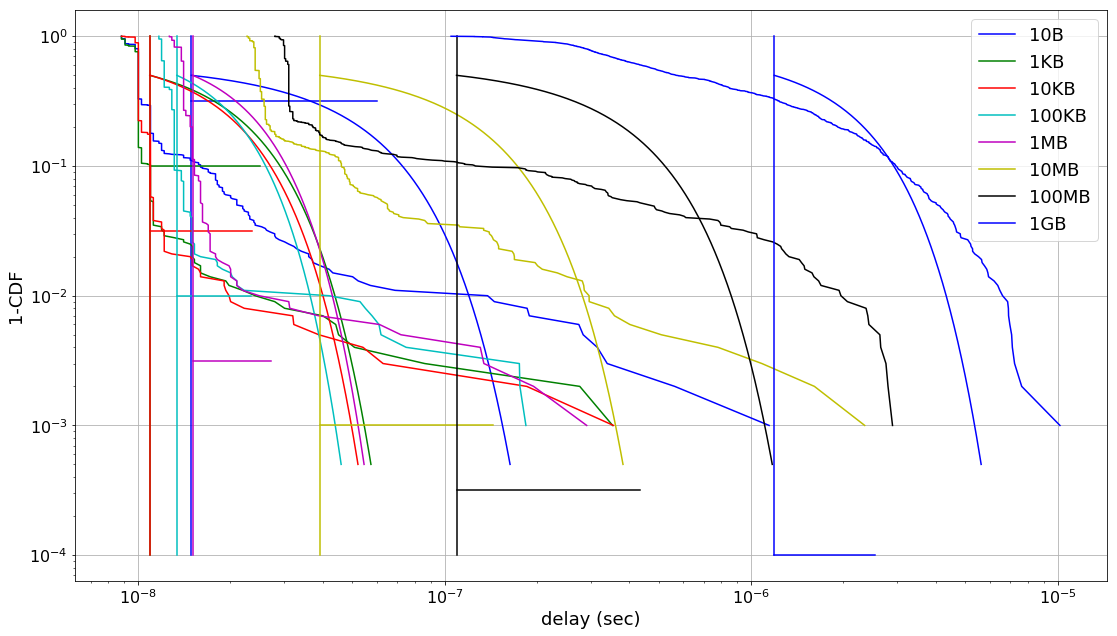

In [13]:
pp = PdfPages('MemoryBlockFigure.pdf')
figure(figsize=(6,4))

Colors='bgrcmyk'  # The colors for the plot
LineStyles=['-']

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)

for m_i in range(len(m_list)):
    Color=Colors[m_i % len(Colors)]
    PlotTime(TMem[m_i],_mean[m_i],_std[m_i],\
             Color=Color,LS='-',Legend=m_legend[m_i],\
             m_i=m_i)

grid()
legend(fontsize=18)
xlabel('delay (sec)',fontsize=18)
ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)
pp.savefig()
pp.close()

### Conclusions

We see that for this laptop (an apple powerbook) the latency of random pokes is close to $10^{-8}$ for blocks of size up to 1 MB. Beyond that, for sizes of 10MB, 100MB and 1GB, the delay is significantly larger.

This makes sense because the size of the L3 cache in this machine is about 6MB.